# Redes Neuronales Artificiales - Trabajo Práctico 2

### Guillermina Cabrol, Magalí Giansiracusa, Sofía Goldberg

In [1]:
%matplotlib widget

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## Introducción

En este trabajo buscamos obtener modelos de redes neuronales artificiales, basados en aprendizaje no supervisado, que logren aprender de un conjunto de documentos con descripciones de texto de compañías brasileñas. La idea es que lo modelos no solo logren aprender estos datos, sino también generalizar sobre nuevas instancias. 

In [2]:
import requests

r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp2_training_dataset.csv')
data = np.loadtxt(r.iter_lines(), delimiter=',')

Para que todos los resultados sean reproducible utilizaremos una seed.

In [3]:
random_seeded = np.random.RandomState(seed=42)

A continuación separamos las categoría de los atributos de cada documento. Además, normalizamos dichos atributos.

In [4]:
categories = data[:,0]

X = data[:,1:]

X = (X - X.mean(axis=0)) / X.std()

## Reducción de dimensión

Nuestro primer objetivo será obtener dos modelos de redes neuronales artificiales que logren reducir la dimensión de los documentos en el conjunto de datos. Éstos van a diferir en la regla utilizada para actualizar los pesos: uno utilizará la **Regla de Oja** y otro la **Regla de Sanger**.

En particular, dada una instancia de dimensión $N$, queremos encontrar una representación de dimensión $M = 9$. Esto se logra llevando las instancias al subespacio generado por sus $9$ primeras componentes principales.

In [5]:
P = X.shape[0]  # Cantidad de instancias
N = X.shape[1]  # Dimensión de entrada
M = 9           # Dimensión de salida

Como criterio de corte para los algoritmos utilizaremos la ortogonalidad, y variaremos el valor óptimo que debe llegar a tomar ésta para encontrar el mejor modelo.

In [24]:
def orthogonality(W: np.ndarray) -> float:
    M = W.shape[1]
    return np.sum(np.abs(np.dot(W.T, W) - np.identity(M))) / 2


Inicializamos los pesos con valores al azar, con una distribución normal:

In [25]:
def initialize_weights(N: int, M: int) -> np.ndarray:
    return random_seeded.normal(0, 0.1, (N, M))

Definimos los algoritmos a utilizar para calcular la corrección de los pesos:

In [26]:
def oja_correction(W: np.ndarray, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    Z = np.dot(Y, W.T)
    return np.outer(X - Z, Y)


def sanger_correction(W: np.ndarray, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    M = W.shape[1]
    D = np.triu(np.ones((M, M)))
    Z = np.dot(W, Y.T * D)
    return (X.T - Z) * Y

Por último, definimos la función que utilizaremos para entrenar la red, en la cual se puede variar el método de cálculo de corrección de los pesos. Ésta, además de reducir la dimensión de los datos, realiza un gráfico de cómo (idealmente) decae la ortogonalidad en cada época de entrenamiento.

Aclaración: usamos la librería `typing` para que queden más claros los tipos que toma la función.

In [41]:
from typing import Callable

CorrectionFunc = Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray]

def PCA_train(
    X: np.ndarray,
    M: int,
    corr: CorrectionFunc,
    *,
    epochs: int = 1000,
    ort_threshold: float = 0.01,
    lr: float = 0.001,
) -> np.ndarray:
    
    fig = plt.figure()

    W = initialize_weights(X.shape[1], M)
    current_lr = lr
    orthogonalities = []

    for t in range(1, epochs + 1):
        for i in range(X.shape[0]):
            x = X[i].reshape(1, -1)
            Y = np.dot(x, W)
            W += current_lr * corr(W, x, Y)

        o = orthogonality(W)
        orthogonalities.append(o)

        if o < ort_threshold:
            break

        if t % 10 == 0:
            print(f"Época: {t:03}, ortogonalidad: {o}")

        current_lr = lr / t
        
    plt.plot(orthogonalities)
    plt.show()

    return W

Además, definimos una función para poder graficar los resultados, usando figuras en el espacio $R^3$.

In [42]:
def graphic_representation(Y: np.ndarray) -> any:
    AX_LIM = 20

    fig = plt.figure(figsize=(10, 10))

    for i in range(3):
        compA, compB, compC = 3 * i, 3 * i + 1, 3 * i + 2

        xyz = fig.add_subplot(1, 3, i + 1, projection="3d")
        xyz.set_xlim(-AX_LIM, AX_LIM)
        xyz.set_ylim(-AX_LIM, AX_LIM)
        xyz.set_zlim(-AX_LIM, AX_LIM)
        xyz.scatter3D(Y[:, compA], Y[:, compB], Y[:, compC], c=categories, cmap='Set1')

        # Labeling
        xyz.set_xlabel(f"PC{compA}")
        xyz.set_ylabel(f"PC{compB}")
        xyz.set_zlabel(f"PC{compC}")

        xyz.set_title(f"PCA Oja - PC{compA} vs PC{compB} vs PC{compC}")

    fig.tight_layout(pad=5.0)

    plt.show()

### Regla de Oja

Época: 010, ortogonalidad: 0.2889718428646114
Época: 020, ortogonalidad: 0.12240720673157768
Época: 030, ortogonalidad: 0.07777359977770072
Época: 040, ortogonalidad: 0.0571899573927646
Época: 050, ortogonalidad: 0.04539489636023446
Época: 060, ortogonalidad: 0.03771111441780542
Época: 070, ortogonalidad: 0.032254335149547085
Época: 080, ortogonalidad: 0.028178258136429726
Época: 090, ortogonalidad: 0.025027514957431156
Época: 100, ortogonalidad: 0.0225111935988222
Época: 110, ortogonalidad: 0.02045467643941828
Época: 120, ortogonalidad: 0.01874247574685845
Época: 130, ortogonalidad: 0.017294794202730664
Época: 140, ortogonalidad: 0.016054725614002646
Época: 150, ortogonalidad: 0.014980595403912845
Época: 160, ortogonalidad: 0.01404118384801285
Época: 170, ortogonalidad: 0.013212640930932806
Época: 180, ortogonalidad: 0.012476432842226685
Época: 190, ortogonalidad: 0.011817938879062495
Época: 200, ortogonalidad: 0.011225470461755033
Época: 210, ortogonalidad: 0.010689571176994768
Época

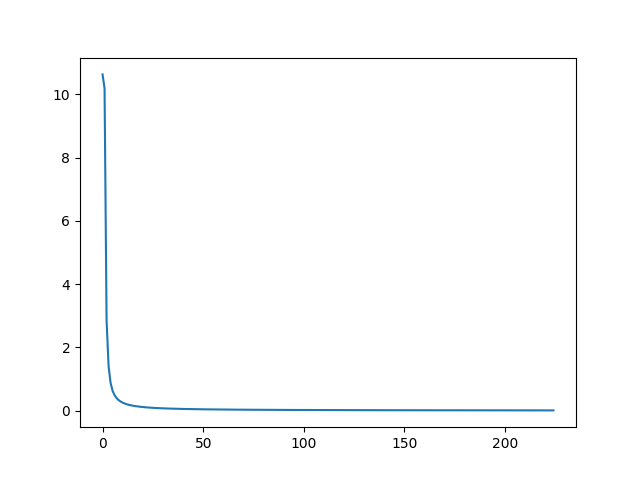

In [43]:
W_oja = PCA_train(X, M, oja_correction)

In [44]:
Y_oja = np.dot(X, W_oja)

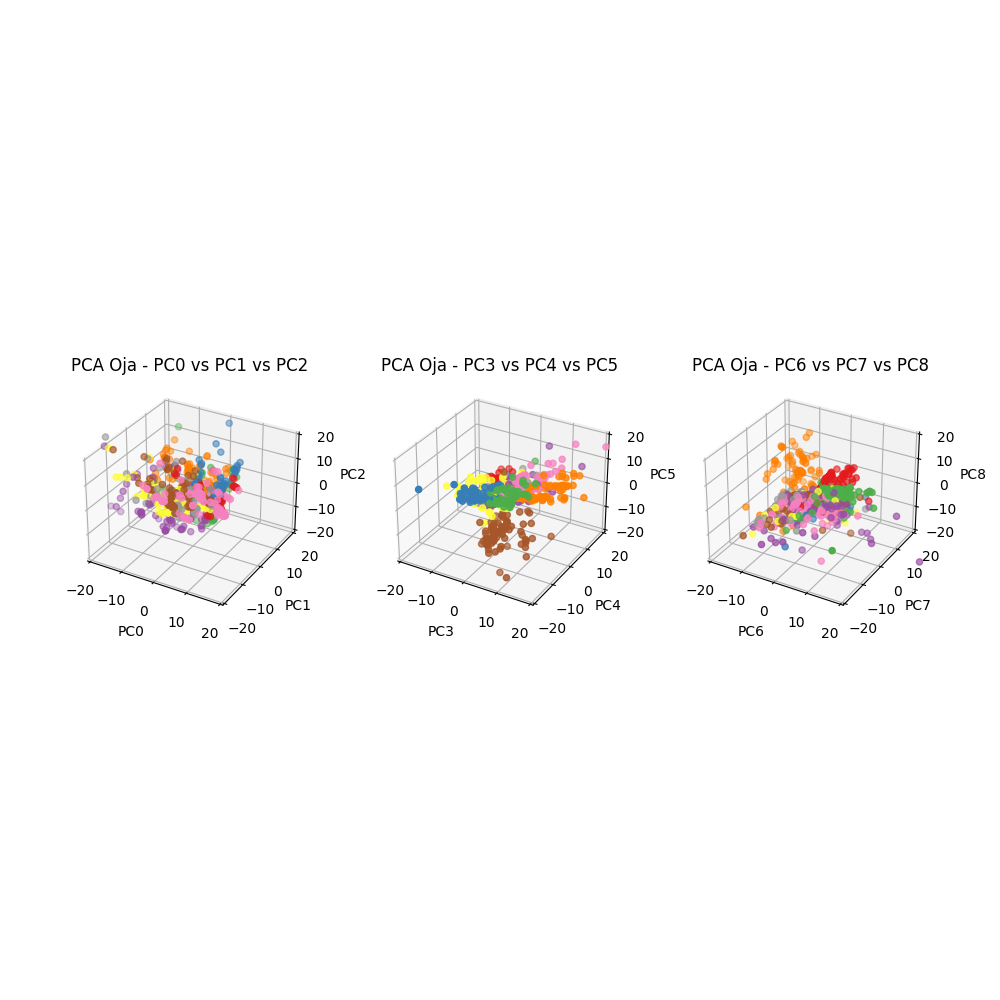

In [45]:
graphic_representation(Y_oja)

### Regla de Sanger

Época: 010, ortogonalidad: 0.9423333435452409
Época: 020, ortogonalidad: 0.5365293101310308
Época: 030, ortogonalidad: 0.3713911617814297
Época: 040, ortogonalidad: 0.28338818076557404
Época: 050, ortogonalidad: 0.22895923513310718
Época: 060, ortogonalidad: 0.1919761652196136
Época: 070, ortogonalidad: 0.16535194509362872
Época: 080, ortogonalidad: 0.14521322346286103
Época: 090, ortogonalidad: 0.12943612883583022
Época: 100, ortogonalidad: 0.11674541938124267
Época: 110, ortogonalidad: 0.10631779044990383
Época: 120, ortogonalidad: 0.09760206983970927
Época: 130, ortogonalidad: 0.09020656556387609
Época: 140, ortogonalidad: 0.0838523039451508
Época: 150, ortogonalidad: 0.07833402070474697
Época: 160, ortogonalidad: 0.07349703352198173
Época: 170, ortogonalidad: 0.06922257772158971
Época: 180, ortogonalidad: 0.06541796020186243
Época: 190, ortogonalidad: 0.06200978181074668
Época: 200, ortogonalidad: 0.05893916831308398
Época: 210, ortogonalidad: 0.05615834855084143
Época: 220, ortogo

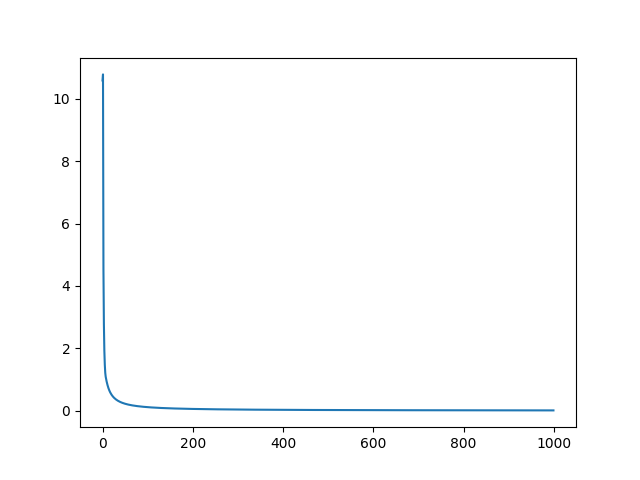

In [46]:
W_sanger = PCA_train(X, M, sanger_correction)

In [47]:
Y_sanger = np.dot(X, W_sanger)

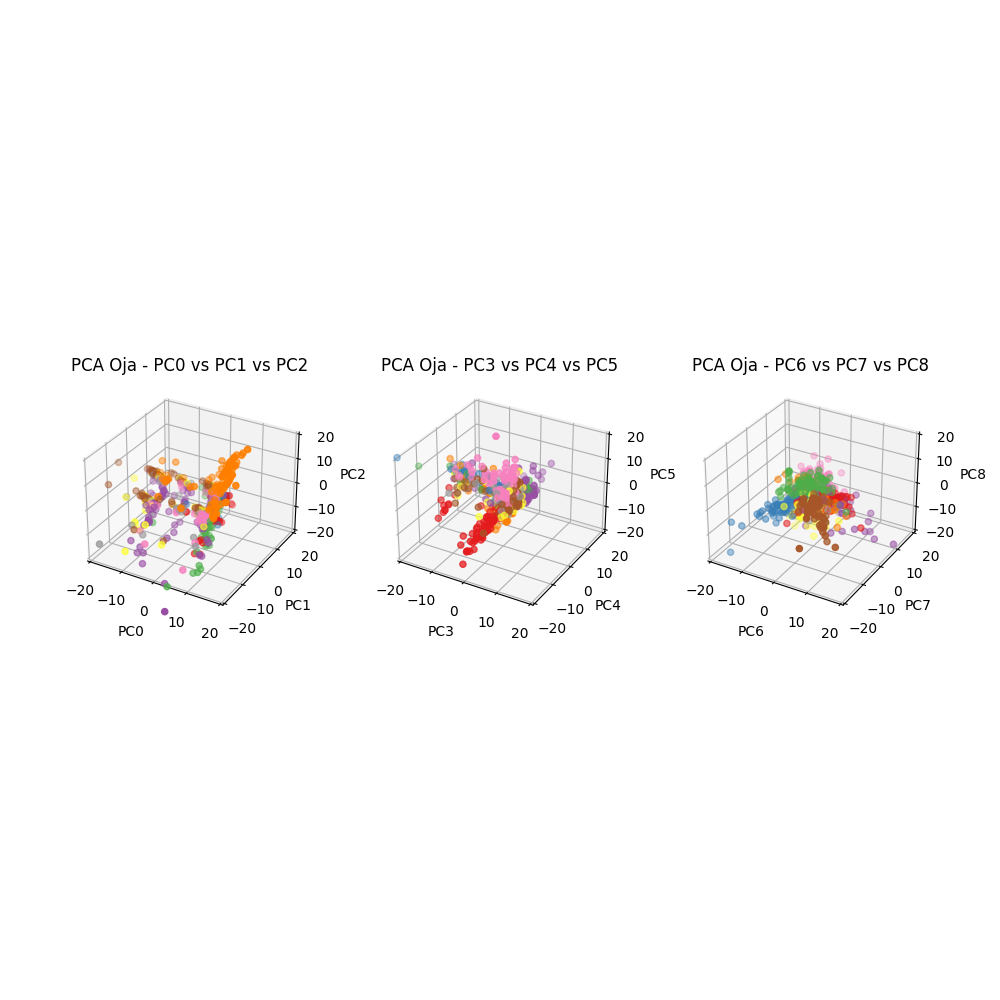

In [48]:
graphic_representation(Y_sanger)

Luego de experimentar con distintos hiperparámetros de entrenamiento, llegamos a las siguientes conclusiones:

- `epochs`: para la cantidad de épocas decidimos usar $1000$, ya que es un número lo suficientemente grande, con el que obtuvimos buenos resultados (se puede ver que baja la ortogonalidad considerablemente), pero no tan alto como para hacer que el entrenamiento tarde demasiado tiempo. Probamos también con menos y más épocas, desde $100$ hasta $5000$, pero, por ejemplo, con $500$ épocas no había una diferencia de tiempo siginificativa comparado con $1000$ y la ortogonalidad final era más alta, mientras que con $5000$ épocas bajaba la ortogonaldidad pero no compensaba con el aumento en tiempo de entrenamiento.

- `ort_threshold`: en el caso de la cota para la ortogonalidad creemos que $0.01$ es un número los suficientemente chico (es decir, cercano a cero), pero el cual no se tarda demasiado en alcanzar.

- `lr`: para que la convergencia del entrenamiento sea más rápida decidimos utilizar un *learning rate* dinámico, es decir, disminuirlo en cada iteración. Esto lo hacemos dividiéndolo por la *epoch* actual. Luego de probar varios valores, obtuvimos los mejores resultados con $lr = 0.001$. Al inicializar el *learning rate* en un valor mayor, los resultados no eran convincentes. En cambio, al disminuir su valor inicial, el entrenamiento era más eficiente en términos de tiempo, pero la ortogonalidad final aumentaba considerablemente. Sin embargo, probamos también aumentando la cantidad de épocas y comenzado con un coeficiente de aprendizaje menor, lo cual produjo mejores resultados, a costa de un mayor tiempo de entrenamiento.



Por otra parte, podemos realizar una comparación entre ambas reglas de aprendizaje utilizadas. En general, la Regla de Oja produce, para este conjunto de datos, mejores resultados en una menor cantidad de tiempo. En todos los casos, usar la Regla de Sanger hacía que el modelo tome más tiempo en convenger, pero siempre mantenía o aumentaba la ortogonalidad final.

## Mapeo de características

In [21]:
N = X.shape[1]
M = 9

In [22]:
epochs = 1000
lr_st = 1.0
lr_dr = 0.001
ir_st = 3
ir_dr = 0.05

In [23]:
Y = np.zeros((M,M))
W = random_seeded.normal( 0,1, (M,M,N))

for t in range(epochs):
   for i in range(X.shape[0]):
        x = X[i]
        e = x - W
        n = np.linalg.norm(e, axis=2)

        p = np.unravel_index(np.argmin(n), n.shape)

        Y[:] = 0
        Y[p] = 1

        lr = lr_st * np.exp(-t * lr_dr)
        ir = ir_st * np.exp(-t * ir_dr)

        il = [[(x, Y) for Y in range(M)] for x in range(M)]
        im = np.array(il)

        d = np.linalg.norm(im-p, axis=2)

        pf = np.exp(-d/(2*np.square(ir))).reshape((M,M,1))

        dW = lr * pf * e
        W += dW



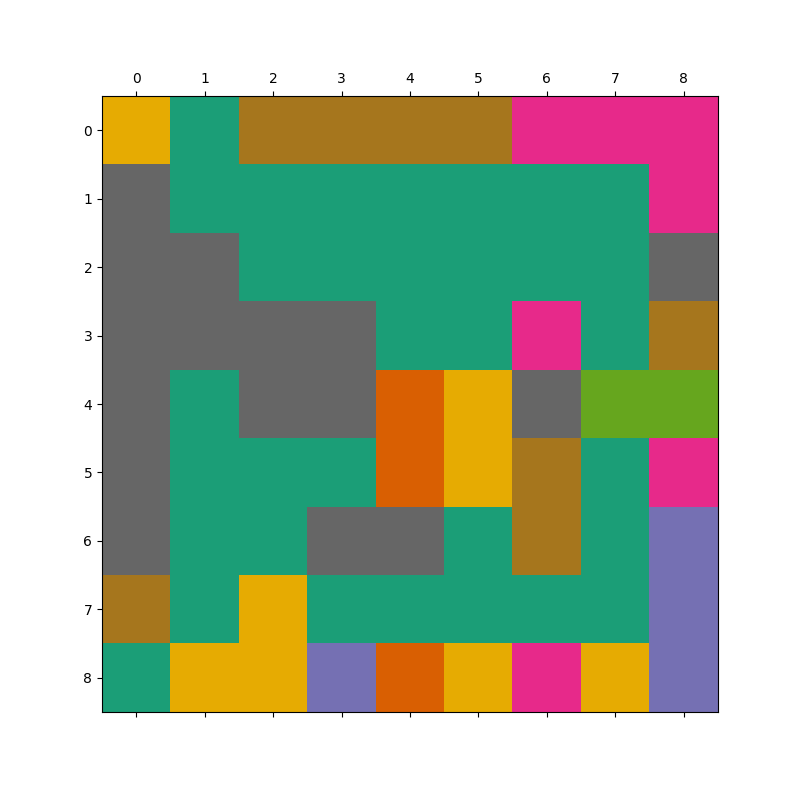

In [20]:
labels = np.arange(1, 10)

predicted_categories = np.zeros((M, M), dtype=int)

for i in range(X.shape[0]):
    x = X[i]
    e = x - W
    n = np.linalg.norm(e, axis=2)
    p = np.unravel_index(np.argmin(n), n.shape)
    predicted_categories[p] = categories[i]

fig, ax = plt.subplots(figsize=(8,8))
cax = ax.matshow(predicted_categories, cmap='Dark2')

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(M))

plt.show()

    

